## Rede Neural do zero
### Etapa 1 - Carregando as bibliotecas e o dataset

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

### Convertendo os dados para Tensor (matriz 2x2)

In [2]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

100%|██████████| 9912422/9912422 [00:00<00:00, 140213583.86it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67222915.55it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64652625.94it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3497435.06it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



### Etapa 2 - Conferindo a estrutura dos dados

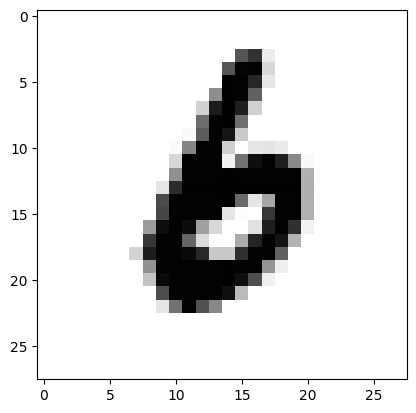

In [5]:
dataiter = iter(trainloader)
for imagens, etiquetas in dataiter:
    plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')
    break

In [6]:
print(imagens[0].shape) # para vermos as dimensões do tensor imagem
print(etiquetas[0].shape) # para vermos as dimensões dos tensor etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [7]:
print(imagens[0])
print(etiquetas[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
          0.8000, 0.0745, 0.0000, 0.0000, 0.0000, 0.0000,

### Etapa 3 - Construindo os elementos da Rede Neural

In [8]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saida não e necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self,X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

##### Função treino

In [9]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a polítca de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 30 # numero de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para  "vetores" de 28*28 casas para ficarem compatíveis com a camada de entrada
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

            perda_instantanea.backward() # back propagation a partir da perda

            otimizador.step() # atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada


        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

##### Função validação

In [10]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens,etiquetas in valloader:
      for i in range(len(etiquetas)):
        img = imagens[i].view(1, 784)
        # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
        with torch.no_grad():
            logps = modelo(img.to(device)) # output do modelo em escala logaritmica


        ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu como correto
        etiqueta_certa = etiquetas.numpy()[i]
        if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
          conta_corretas += 1
        conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

### Etapa 4 - Rodando a rede neural

##### Inicializando o modelo

In [11]:
modelo = Modelo() # inicializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

##### Treinando o modelo

In [12]:
treino(modelo, trainloader, device)

Epoch 1 - Perda resultante: 1.1724999810396226
Epoch 2 - Perda resultante: 0.37840288326239535
Epoch 3 - Perda resultante: 0.308103489095786
Epoch 4 - Perda resultante: 0.2698843506639446
Epoch 5 - Perda resultante: 0.23945859644903558
Epoch 6 - Perda resultante: 0.21348779580232177
Epoch 7 - Perda resultante: 0.19066419755456163
Epoch 8 - Perda resultante: 0.17236396833372586
Epoch 9 - Perda resultante: 0.15757787336847548
Epoch 10 - Perda resultante: 0.14513524328030822
Epoch 11 - Perda resultante: 0.1342637100830865
Epoch 12 - Perda resultante: 0.12492898766642441
Epoch 13 - Perda resultante: 0.11647847854395284
Epoch 14 - Perda resultante: 0.1092996838560173
Epoch 15 - Perda resultante: 0.10241177856032528
Epoch 16 - Perda resultante: 0.09629803183061608
Epoch 17 - Perda resultante: 0.09114493693270759
Epoch 18 - Perda resultante: 0.08579504560691112
Epoch 19 - Perda resultante: 0.08134796516572647
Epoch 20 - Perda resultante: 0.07721619470231632
Epoch 21 - Perda resultante: 0.0732

##### Validando o Modelo

In [13]:
validacao(modelo, valloader, device)

Total de imagens testadas = 10000

Precisão do modelo = 97.72%
